**Import Library**

In [1]:
import pandas as pd
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


**Baca File**

**Parsing kolom JSON**

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Time,Data URI,Content
0,2024-12-20T20:10:05.000Z,/antares-cse/cin-HzbOZk3H16sKwojRyqGSjwl4BNcAAmyZ,"{""tds"":""0"",""ph"":""6.5"",""temperature"":""29.12"",""w..."
1,2024-12-20T20:10:20.000Z,/antares-cse/cin-aLCqgFm6Jlvh2BOicP98XimVXJm72cl6,"{""tds"":""0"",""ph"":""6.5"",""temperature"":""29.12"",""w..."
2,2024-12-20T20:10:35.000Z,/antares-cse/cin-vMdtbqPMCMnGJfIUKrncC4gByCp8pxLs,"{""tds"":""0"",""ph"":""6.5"",""temperature"":""29.12"",""w..."
3,2024-12-20T20:10:50.000Z,/antares-cse/cin-UZmAXvGNaqHqCw8mYuhJIOHvw4Zn0VLp,"{""tds"":""0"",""ph"":""6.5"",""temperature"":""29.12"",""w..."
4,2024-12-20T20:11:05.000Z,/antares-cse/cin-e1lBgnUP5SNuIjwz8pWSdELK9ZD3VSxg,"{""tds"":""0"",""ph"":""6.5"",""temperature"":""29.12"",""w..."


In [3]:
content_parsed = df['Content'].apply(json.loads).apply(pd.Series)
df_cleaned = pd.concat([df, content_parsed[['ph', 'temperature', 'tds']]], axis=1)

**Preprocessing**

In [4]:
df_cleaned.dropna(subset=['ph', 'temperature', 'tds'], inplace=True)
df_cleaned.drop_duplicates(inplace=True)
df_cleaned['ph'] = df_cleaned['ph'].astype(float)
df_cleaned['temperature'] = df_cleaned['temperature'].astype(float)
df_cleaned['tds'] = df_cleaned['tds'].astype(float)
df_cleaned['Time'] = pd.to_datetime(df_cleaned['Time'])
df_cleaned.set_index('Time', inplace=True)

**Resample setiap 30 menit**

In [5]:
df_resampled = df_cleaned[['ph', 'temperature', 'tds']].resample('30min').mean().dropna()
df_resampled

,ph,temperature,tds
Time,,,
2024-12-20 20:00:00+00:00,3.686957,29.108406,81.594203
2024-12-20 20:30:00+00:00,-2.000000,25.000000,117.000000
2024-12-21 04:00:00+00:00,-1.454545,25.000000,0.000000
2024-12-21 07:30:00+00:00,-2.000000,27.373333,0.000000
2025-01-14 11:30:00+00:00,-2.000000,25.000000,0.000000
...,...,...,...
2025-01-22 02:30:00+00:00,7.497436,22.217692,189.017094
2025-01-22 03:00:00+00:00,7.498214,22.186786,188.508929
2025-01-22 03:30:00+00:00,7.494872,22.138205,188.401709


**Clustering**

In [6]:
X = df_resampled[['ph', 'temperature', 'tds']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_resampled['cluster'] = kmeans.fit_predict(X_scaled)

**Cek imbalance cluster**

In [7]:
print("📊 Distribusi Data per Cluster:")
print(df_resampled['cluster'].value_counts())

📊 Distribusi Data per Cluster:
cluster
1    187
0     67
2     10
Name: count, dtype: int64


**Evaluasi clustering (Silhouette Score)**

In [8]:
sil_score = silhouette_score(X_scaled, df_resampled['cluster'])
print(f"\n📈 Silhouette Score: {sil_score:.3f}")


📈 Silhouette Score: 0.719


**Visualisasi**

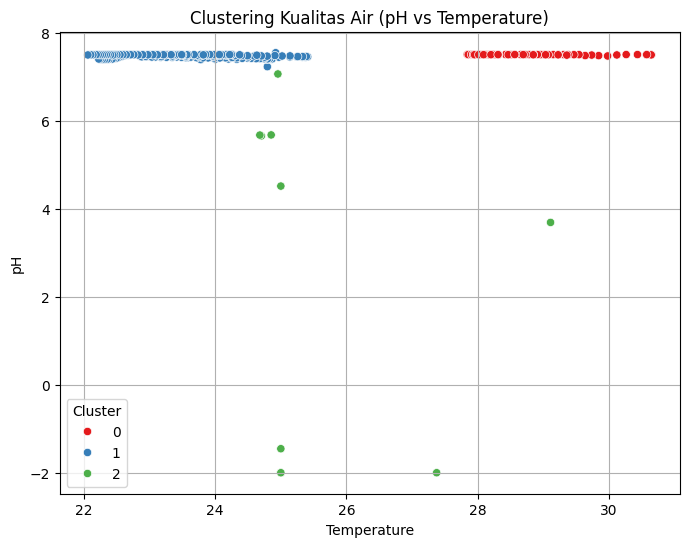

In [9]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_resampled,
    x='temperature',
    y='ph',
    hue='cluster',
    palette='Set1'
)
plt.title('Clustering Kualitas Air (pH vs Temperature)')
plt.xlabel('Temperature')
plt.ylabel('pH')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

**Labeling kualitas**

In [10]:
cluster_means = df_resampled.groupby('cluster')[['ph', 'temperature', 'tds']].mean()
print("\n📌 Rata-rata Setiap Cluster:")
print(cluster_means)

label_map = {
    2: 'Baik',
    1: 'Cukup',
    0: 'Buruk'
}
df_resampled['kualitas_air'] = df_resampled['cluster'].map(label_map)


📌 Rata-rata Setiap Cluster:
               ph  temperature         tds
cluster                                   
0        7.498103    28.731538  209.152277
1        7.468510    23.508693  211.318661
2        2.480558    25.567284   19.859420


**Fungsi Prediksi Baru**

In [11]:
def prediksi_kualitas_air(suhu, ph, tds):
    input_data = pd.DataFrame([[ph, suhu, tds]], columns=['ph', 'temperature', 'tds'])
    input_scaled = scaler.transform(input_data)
    cluster_pred = kmeans.predict(input_scaled)[0]
    kualitas = label_map[cluster_pred]
    return kualitas

**Simpan model**

In [12]:
import joblib
joblib.dump(kmeans, 'model_kmeans.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_map, 'label_map.pkl')

['label_map.pkl']

**Prediksi**

In [14]:
suhu_user = 28
ph_user = 7.4
tds_user = 209
hasil = prediksi_kualitas_air(suhu_user, ph_user, tds_user)
print(f"\n✅ Prediksi kualitas air: {hasil}")


✅ Prediksi kualitas air: Buruk
